In [54]:
#!pip install ipywidgets
#!jupyter nbextension enable --py widgetsnbextension
import scipy as sp
import scipy.io
import scipy.stats
import os
import numpy as np
import pandas as pd
import glob
import csv
import random as rand
from tqdm import tnrange, tqdm_notebook
import sys
sys.path.append(os.getcwd()+'\\..')
from utils import utils
import cmocean
import matplotlib.patches as patches
from matplotlib import gridspec

from collections import Iterable
import matplotlib.pylab as mpl
import random as rand
from ipywidgets import *
import colorlover as cl
from utils import zscores

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize


In [2]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 20}

mpl.rc('font', **font)
mpl.rc('xtick', labelsize=20) 
mpl.rc('ytick', labelsize=20)
mpl.rc('axes', labelsize=20)

In [3]:
% pwd

'C:\\Users\\efink\\Documents\\Github\\crossmodal\\Figure3'

# Load data and prepare data
## Load behavior and spike data

In [4]:
bin_size = 0.025
window = [-1, 3]
edges = np.arange(window[0], window[1], bin_size)

In [ ]:
DATA_DIR = os.path.abspath('../data')
log_df = pd.read_hdf(os.path.join(DATA_DIR, 'log_df_processed_02-28-2019.h5'), 'fixed')
unit_key_df = pd.read_hdf(os.path.join(DATA_DIR, 'unit_key_df_processed_02-28-2019.h5'), 'fixed')

In [55]:
unit_key_df = zscores.calc_z_scores(log_df, unit_key_df, bin_size, window)

#### drop units that have a baseline mean and std of 0 otherwise Z-score will be NaN
unit_key_df = unit_key_df[~(unit_key_df['FR_std'] == 0)]

HBox(children=(IntProgress(value=0, max=2931), HTML(value='')))

C:\Users\efink\Documents\Github\crossmodal\Figure3\..\utils\zscores.py:94: RuntimeWarning: Mean of empty slice
  act_resp_touch  = act_resp_touch.apply(lambda y: np.nanmean(y))
C:\Users\efink\Documents\Github\crossmodal\Figure3\..\utils\zscores.py:95: RuntimeWarning: Mean of empty slice
  act_resp_vis  = act_resp_vis.apply(lambda y: np.nanmean(y))


In [53]:
data_directory = r'C:\Users\efink\Documents\DATA\Crossmodal_only'
log_df, unit_key_df = utils.load_data(data_directory)
unit_key_df = utils.calc_unit_stats(unit_key_df, log_df, bin_size)

log_df['spike_counts(stim_aligned)'] = log_df['spike_times(stim_aligned)'].apply(lambda x: np.histogram(x,edges)[0]/bin_size)

unit_key_df = zscores.calc_z_scores(log_df, unit_key_df, bin_size, window)

#### drop units that have a baseline mean and std of 0 otherwise Z-score will be NaN
unit_key_df = unit_key_df[~(unit_key_df['FR_std'] == 0)]

##### uncomment below if the processed data is already saved
# log_df = pd.read_hdf(f'{data_directory}/log_df_processed_02-28-2019.h5', 'fixed')
# unit_key_df = pd.read_hdf(f'{data_directory}/unit_key_df_processed_02-28-2019.h5', 'fixed')

C:\Users\efink\Anaconda3\lib\site-packages\pandas\core\groupby.py:933: RuntimeWarning: Mean of empty slice
  f = lambda x: func(x, *args, **kwargs)
C:\Users\efink\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
C:\Users\efink\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


HBox(children=(IntProgress(value=0, max=2931), HTML(value='')))

NameError: name 'zscores' is not defined

### Remove any units that were recorded from tactile lick-left/visual lick-right mice

In [56]:
unit_key_df = unit_key_df[~(unit_key_df['mouse_name'].isin(['EF0083','EF0085', 'EF0112', 'EF0111']))] # these are mice with tetrodes not implanted in pricipal whisker
unit_key_df['mouse_name'].unique()

array(['EF0074', 'EF0076', 'EF0077', 'EF0079', 'EF0081', 'EF0084',
       'EF0088', 'EF0089', 'EF0091', 'EF0099', 'EF0101', 'EF0102',
       'EF0114'], dtype=object)

### load auc data

In [57]:
tactile_lick_noLick_aucs = pd.read_hdf(r'C:\Users\efink\Documents\DATA\Crossmodal_only\Touch_lick_no_lick_auc_2019-02-27.h5', 'table')
visual_lick_noLick_aucs = pd.read_hdf(r'C:\Users\efink\Documents\DATA\Crossmodal_only\Visual_lick_no_lick_auc_2019-02-27.h5', 'table')

In [58]:
visual_lick_noLick_aucs['mouse_name'].drop_duplicates().values

array(['EF0074', 'EF0076', 'EF0077', 'EF0079', 'EF0081', 'EF0083',
       'EF0084', 'EF0085', 'EF0088', 'EF0089', 'EF0091', 'EF0099',
       'EF0101', 'EF0102', 'EF0114'], dtype=object)

### filter auc data for tactile lick-right/ visual lick-left  data 

In [59]:
tactile_lick_noLick_aucs = tactile_lick_noLick_aucs.merge(unit_key_df['uni_id'].to_frame(), on = 'uni_id', how = 'right')
visual_lick_noLick_aucs = visual_lick_noLick_aucs.merge(unit_key_df['uni_id'].to_frame(), on = 'uni_id', how = 'right')
visual_lick_noLick_aucs.shape

(2103, 483)

# Identify units with a significant detect probability (DP) and define onset times

In [60]:
auc_col_names = tactile_lick_noLick_aucs.columns[tactile_lick_noLick_aucs.columns.str.contains('auc')]
low_conf_col_names = tactile_lick_noLick_aucs.columns[tactile_lick_noLick_aucs.columns.str.contains('low')]
up_conf_col_names =tactile_lick_noLick_aucs.columns[tactile_lick_noLick_aucs.columns.str.contains('up')]

In [61]:
# find bins where auc is significant 
raw_tac_sig_AUC = pd.DataFrame(~((tactile_lick_noLick_aucs.loc[:,low_conf_col_names].fillna(0.5) >= 0.5).as_matrix() & 
                    (tactile_lick_noLick_aucs.loc[:,up_conf_col_names].fillna(0.5) <= 0.5).as_matrix())*1, index = tactile_lick_noLick_aucs['uni_id'])

raw_vis_sig_AUC = pd.DataFrame(~((visual_lick_noLick_aucs.loc[:,low_conf_col_names].fillna(0.5) >= 0.5).as_matrix() & 
                    (visual_lick_noLick_aucs.loc[:,up_conf_col_names].fillna(0.5) <= 0.5).as_matrix())*1, index = visual_lick_noLick_aucs['uni_id'])

# identify direction of significant bins
auc_dir_t = (tactile_lick_noLick_aucs.loc[:,auc_col_names] >= 0.5)*1 + (tactile_lick_noLick_aucs.loc[:,auc_col_names] < 0.5)*-1
auc_dir_v = (visual_lick_noLick_aucs.loc[:,auc_col_names] >= 0.5)*1 + (visual_lick_noLick_aucs.loc[:,auc_col_names] < 0.5)*-1
auc_dir_v = (visual_lick_noLick_aucs.loc[:,auc_col_names] >= 0.5)*1 + (visual_lick_noLick_aucs.loc[:,auc_col_names] < 0.5)*-1
auc_dir_t.index = tactile_lick_noLick_aucs['uni_id']; auc_dir_t.columns = raw_tac_sig_AUC.columns
auc_dir_v.index = visual_lick_noLick_aucs['uni_id']; auc_dir_v.columns = raw_vis_sig_AUC.columns

raw_tac_sig_AUC = raw_tac_sig_AUC*auc_dir_t
raw_vis_sig_AUC = raw_vis_sig_AUC*auc_dir_v

In [62]:
# take running sum of bins to identify bins with consecutive significant bins
smooth_tac_sig_AUC = raw_tac_sig_AUC.apply(lambda y: np.convolve(y, [1,1], 'same'), axis = 1)
smooth_vis_sig_AUC = raw_vis_sig_AUC.apply(lambda y: np.convolve(y, [1,1], 'same'), axis = 1)

### to get the first bin of 2 that are significantly different from 0 need to subtract 1 from all_sig_tac/vis since convolve 
### was used with 'same' setting (otherwise would need to subtract 2 if setting was 'full')
all_sig_tac = (smooth_tac_sig_AUC.isin([2,-2])*1).apply(lambda y: np.where(y), axis = 1)
all_sig_tac = all_sig_tac.apply(lambda y: (y[0]-1)*bin_size-1 if len(y[0])>0 else [])

all_sig_vis = (smooth_vis_sig_AUC.isin([2,-2])*1).apply(lambda y: np.where(y), axis = 1)
all_sig_vis = all_sig_vis.apply(lambda y: (y[0]-1)*bin_size-1 if len(y[0])>0 else [])

### find first significant bin for each unit for each modality
all_first_sig_tac = all_sig_tac.apply(lambda y:  y[(y>=0) & (y<1)] if len(y)!=0 else []) 
all_first_sig_tac = all_first_sig_tac.apply(lambda y:  np.nan if len(y)==0 else np.min(y))

all_first_sig_vis = all_sig_vis.apply(lambda y:  y[(y>=0) & (y<1)] if len(y)!=0 else [])
all_first_sig_vis = all_first_sig_vis.apply(lambda y:  np.nan if len(y)==0 else np.min(y))
dp_onsets = pd.merge(all_first_sig_vis.to_frame(name = 'vis_dp_onset').reset_index(), all_first_sig_tac.to_frame(name = 'tac_dp_onset').reset_index(), how = 'outer')

In [63]:
# bimodal_lick_units = pd.read_hdf('bimodal_lick_units.h5', 'table') 
# touch_lick_units = pd.read_hdf('touch_lick_units.h5', 'table')
# vis_lick_units = pd.read_hdf('vis_lick_units.h5', 'table') 

In [64]:
unit_key_df = pd.merge(unit_key_df, dp_onsets, on = 'uni_id')

In [65]:
bimodal_lick_units = unit_key_df.dropna(subset = ['vis_dp_onset', 'tac_dp_onset']).copy()
# touch_and_bimodal = pd.concat([bimodal_lick_units, touch_lick_units], axis = 0)
# visual_and_bimodal = pd.concat([bimodal_lick_units, vis_lick_units], axis = 0)

In [66]:
import matplotlib.patches as patches
from matplotlib import gridspec
def plot_rasters(rasters, window, bin_size, stim_type, ylim=None, st_len = 'long'):
    mpl.close('all')
    fig = mpl.figure(figsize=(8, 7))
    first_raster = rasters[0]
    fig.suptitle (rasters[0].iloc[0,0] +', '+ rasters[0].iloc[0, 1] +', '+ rasters[0].iloc[0, 13], size = 22)

    gs1 = gridspec.GridSpec(1,1)
    gs2 = gridspec.GridSpec(2,1)
    gs3 = gridspec.GridSpec(2,1)
    gs1.update(bottom = 0.81, top=0.87, left = 0.2, right = 0.82)
    gs2.update(bottom=0.1, top=0.8, left = 0.2, right = 0.82)
    gs3.update(bottom=0.1, top=0.8, left = 0.83, right = 0.9)
    ax1 = mpl.subplot(gs1[0, 0])
    ax2 = mpl.subplot(gs2[0, 0])
    ax3 = mpl.subplot(gs2[1, 0])
    patch_ax = mpl.subplot(gs3[0, 0], sharey = ax2)

    ax1.axis('off')
    hists = []
    
    if stim_type == 'short visual':
        colors = ['C7','#cc4c02', '#fed98e']
        ax1.add_patch(patches.Rectangle((0,0),  0.05, 1, facecolor = '#feb24c', alpha = 0.5))
        ax3.text(.55, .7, "Short visual Lick" , size=20, transform=ax3.transAxes, color = colors[1])
        ax3.text(.55, .6, "Short visual no Lick" , size=20, transform=ax3.transAxes, color = colors[0])
    elif stim_type == 'short touch':
        colors = ['C7','b', '#6baed6']
        ax1.add_patch(patches.Rectangle((0,0),  0.05, 1, facecolor = 'c', alpha = 0.5))
        ax3.text(.55, .7, "Short touch Lick" , size=20, transform=ax3.transAxes, color = colors[1])
        ax3.text(.55, .6, "Short touch no Lick" , size=20, transform=ax3.transAxes, color = colors[0])
    elif stim_type == 'touch':
        colors = ['C7','b', '#6baed6']
        ax1.add_patch(patches.Rectangle((0,0),  0.15, 1, facecolor = 'C0', alpha = 0.5))
        ax3.text(.6, .7, "Touch-Lick" , size=20, transform=ax3.transAxes, color = colors[1])
        ax3.text(.6, .6, "Touch-no Lick" , size=20, transform=ax3.transAxes, color = colors[0])      
    elif stim_type == 'visual':
        colors = ['C7','#cc4c02', '#fed98e']
        ax1.add_patch(patches.Rectangle((0,0),  0.15, 1, facecolor = 'C1', alpha = 0.5))
        ax3.text(.6, .7, "Visual-Lick" , size=20, transform=ax3.transAxes, color = colors[1])
        ax3.text(.6, .6, "Visual-no Lick" , size=20, transform=ax3.transAxes, color = colors[0])       

    mpl.sca(ax2)
    trial_type = 0
    trial_total = 0
    for i in range(3):
        ras = rasters[trial_type]
        spike_counts = []
        for trial, spike in enumerate(ras['spike_times(stim_aligned)']):
            spike = spike[(spike>window[0]) & (spike<=window[1])]
            mpl.vlines(spike, trial + trial_total + .5, trial + trial_total + 1.5)
            mpl.vlines(ras.iloc[trial]['first_lick'], trial + trial_total + .5, trial +
                       trial_total + 1.5, color = colors[i], linewidth = 5)
           
            spike = spike[(spike>window[0]) & (spike<=window[1])]
            edges = np.arange(window[0], window[1]+bin_size*2, bin_size)
            count, _ = np.histogram(spike,edges)
            spike_counts.append(count)
            
        c1 = 0 + 0.5*trial_type
        c2 = 0.5 + 0.5*trial_type
   
        hists.append(np.array(spike_counts))
        patch_ax.add_patch(patches.Rectangle((window[0],trial_total+c1), window[1]-window[0],
                                       trial + c2, facecolor = colors[trial_type], alpha = 0.5)) 
        trial_total += trial
        trial_type += 1
        
    ax2.set_xlabel('Time(s)', fontsize = 20)
    ax2.set_ylabel('Trials', fontsize= 20)

    from scipy import stats
    average_hists = []
    SE_hists =[]
    colors = colors[::-1]
    for i, hist in enumerate(hists[::-1]):
        average_hists.append(np.mean(hist, axis=0)/bin_size)
        SE_hists.append(stats.sem(hist)/bin_size)
        
        ax3.plot(edges[0:-1], average_hists[i], color = colors[i])
        ax3.fill_between(edges[0:-1], average_hists[i]-SE_hists[i],
                        average_hists[i]+SE_hists[i], alpha = 0.5, color = colors[i])
    
   
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.xaxis.set_ticks_position('bottom')
    ax3.yaxis.set_ticks_position('left')
    ax3.set_xlabel('Time from stim onset(s)', fontsize = 20)
    ax3.set_ylabel('Firing Rate (Hz)', fontsize= 20)
    
    if ylim != None:
        ax3.set_ylim(ylim)

    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.axes.get_xaxis().set_visible(False)
    gs2.update(hspace=0.05)
    gs3.update(hspace=0.05)
    ax2.yaxis.set_ticks_position('left')
    ax2.set_ylim(0.5, trial_total+.5)    
        
    ax1.set_ylim(0,2)
    patch_ax.axis('off')
    for ax in [ax1,ax2,ax3]:
        ax.set_xlim(window[0],window[1]-bin_size)
        
    return fig, average_hists, SE_hists

In [67]:
def plot_unit(current_cell, x_min, x_max, stim_type = 'touch', ylim=None):
    if stim_type == 'touch':
        stim = current_cell['trial_type'] == 'Stim_Som_NoCue'
        lick = (current_cell['response'] == 1)
    elif stim_type == 'short touch':
        stim = current_cell['trial_type'] == '1CycStim_Som_NoCue'
        lick = (current_cell['response'] == 1)
    elif stim_type == 'visual':
        stim = current_cell['trial_type'] == 'Stim_Vis_NoCue'
        lick = (current_cell['response'] == 2)
    elif stim_type == 'short visual':
        stim = current_cell['trial_type'] == '1CycStim_Vis_NoCue'
        lick = (current_cell['response'] == 2)
#     lick = (current_cell['response'] == )
    no_lick = current_cell['response'] == 0
    
    stim_no_lick_rows = current_cell[stim & no_lick][0:30]
    stim_lick_rows = current_cell[stim & lick]
                                     
    terciles = stim_lick_rows['first_lick'].quantile([.33, .67])
    first_tercile = stim_lick_rows[stim_lick_rows['first_lick'] <= terciles[.33]]
    second_tercile = stim_lick_rows[(stim_lick_rows['first_lick'] > terciles[.33]) &
                                    ((stim_lick_rows['first_lick'] < terciles[.67]))]
    third_tercile = stim_lick_rows[stim_lick_rows['first_lick'] >= terciles[.67]]


    rasters = [stim_no_lick_rows ,first_tercile, third_tercile]
    fig = plot_rasters(rasters, [x_min, x_max], 0.025, ylim = ylim, stim_type = stim_type)[0]

    return fig

In [68]:
unit_ids = bimodal_lick_units[['mouse_name', 'date', 'cluster_name']]
unit_rows = pd.merge(log_df, unit_ids.iloc[13].to_frame().T, on = ['mouse_name', 'date', 'cluster_name'], how = 'inner')

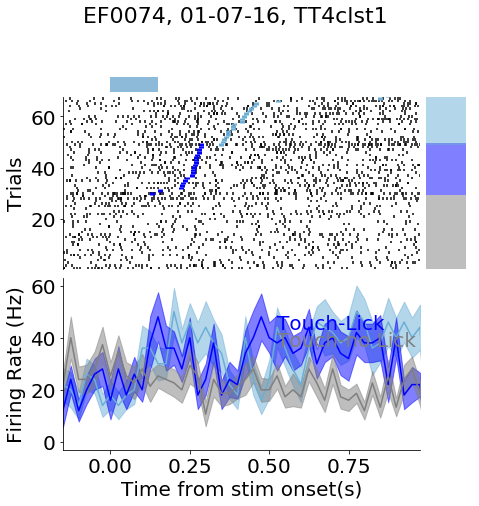

In [69]:
mpl.close('all')
fig = plot_unit(unit_rows, -0.15, 1, stim_type = 'touch')

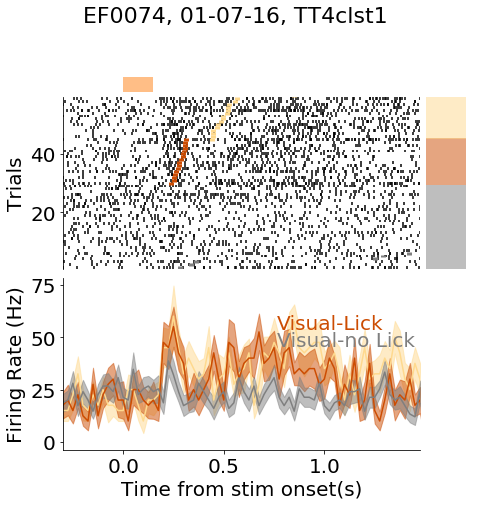

In [70]:
mpl.close('all')
fig = plot_unit(unit_rows, -0.3, 1.5, stim_type = 'visual')

In [71]:
# unit_ids = touch_and_bimodal[['mouse_name', 'date', 'cluster_name']]

def get_tercile_rows(subset_df, stim_type):
    unit_ids = subset_df[['mouse_name', 'date', 'cluster_name']].drop_duplicates()
    for unit_num in tnrange(unit_ids.shape[0]):
        unit_rows = subset_df.reset_index().merge(unit_ids.iloc[unit_num].to_frame().T, 
                             on = ['mouse_name', 'date', 'cluster_name'], how = 'inner').set_index('index')
        if stim_type == 'touch':
            stim = unit_rows['trial_type'] == 'Stim_Som_NoCue'
        elif stim_type == 'short touch':
            stim = unit_rows['trial_type'] == '1CycStim_Som_NoCue'
        elif stim_type == 'visual':
            stim = unit_rows['trial_type'] == 'Stim_Vis_NoCue'
        elif stim_type == 'short visual':
            stim = unit_rows['trial_type'] == '1CycStim_Vis_NoCue'
            
        lick = (unit_rows['response'] != 0) & (unit_rows['correct'] == 1)
        no_lick = (unit_rows['response'] == 0) & (unit_rows['correct'] == 1)

        stim_no_lick_rows = unit_rows[stim & no_lick]
        stim_lick_rows = unit_rows[stim & lick]
        
        no_lick = list(stim_no_lick_rows.index)
        terciles = stim_lick_rows['first_lick'].quantile([.33, .67])
        first_terc = (list(stim_lick_rows.index[stim_lick_rows['first_lick'] <= terciles[.33]]))
        second_terc = (list(stim_lick_rows.index[(stim_lick_rows['first_lick'] > terciles[.33]) &
                                        ((stim_lick_rows['first_lick'] < terciles[.67]))]))
        third_terc = (list(stim_lick_rows.index[stim_lick_rows['first_lick']
                                                         >= terciles[.67]]))
        subset_df.loc[no_lick, 'terc_group'] = 0
        subset_df.loc[first_terc, 'terc_group'] = 1
        subset_df.loc[second_terc, 'terc_group'] = 2
        subset_df.loc[third_terc, 'terc_group'] = 3
        
    return subset_df


In [ ]:
id_cols = ['mouse_name', 'date', 'cluster_name']
bi_units_trials = pd.merge(log_df, bimodal_lick_units[id_cols], on = id_cols, how = 'inner')
bi_units_trials['terc_group'] = -1
bi_units_trials = get_tercile_rows(bi_units_trials, stim_type = 'touch')
bi_units_trials = get_tercile_rows(bi_units_trials, stim_type = 'visual')
bi_units_trials = bi_units_trials[~bi_units_trials['trial_type'].str.contains('1Cyc')].reset_index(drop=True)

HBox(children=(IntProgress(value=0, max=666), HTML(value='')))

HBox(children=(IntProgress(value=0, max=666), HTML(value='')))

In [ ]:
window = [-1, 3]
edges = np.arange(window[0], window[1], bin_size)

bi_units_trials['spike_counts(stim_aligned)'] = bi_units_trials['spike_times(stim_aligned)'].apply(
    lambda x: np.histogram(x,edges)[0]/bin_size)


conds = ['t_stim_no_lick', 't_stim_lick_first_terc', 't_stim_lick_second_terc', 't_stim_lick_third_terc',
        'v_stim_no_lick', 'v_stim_lick_first_terc', 'v_stim_lick_second_terc', 'v_stim_lick_third_terc']

z_conds = ['t_stim_no_lick(z_score)', 't_stim_lick_first_terc(z_score)', 't_stim_lick_second_terc(z_score)',
           't_stim_lick_third_terc(z_score)','v_stim_no_lick(z_score)', 'v_stim_lick_first_terc(z_score)',
           'v_stim_lick_second_terc(z_score)', 'v_stim_lick_third_terc(z_score)']

for c in range(8):
    bimodal_lick_units[conds[c]] = np.nan
    bimodal_lick_units[conds[c]] = bimodal_lick_units[conds[c]].astype(object)
    bimodal_lick_units[z_conds[c]] = np.nan
    bimodal_lick_units[z_conds[c]] = bimodal_lick_units[z_conds[c]].astype(object)
    

In [ ]:
unit_key_df.columns

In [ ]:
bimodal_lick_units['FR_mean'] = np.nan
bimodal_lick_units['FR_std'] = np.nan

for num in tnrange(len(bimodal_lick_units.index)):
    unit = bimodal_lick_units.index[num]
    unit_rows = bi_units_trials[(bi_units_trials['mouse_name'] == bimodal_lick_units.loc[unit, 'mouse_name']) &
                              (bi_units_trials['date'] == bimodal_lick_units.loc[unit,'date']) &
                              (bi_units_trials['cluster_name'] == bimodal_lick_units.loc[unit,'cluster_name'])]
    mouse_name = unit_rows['mouse_name'].iloc[0]
    date = unit_rows['date'].iloc[0]
    cluster_name = unit_rows['cluster_name'].iloc[0]
    
    ## since there are 8 trial types (short/long x touchStim/visStim x touchBlock/visBlock) will use random sample of
    ## 1/8 of all trials to calculate mean and std of baseline firing rate for each unit
    baseline_trial_inds = rand.sample(list(unit_rows.index), int(np.max(unit_rows['trial_num'])/24))
    bin_means = np.mean(np.stack(unit_rows.loc[baseline_trial_inds, 
                                               'baseline_spike_count'].as_matrix(), axis = 0), axis=0)/bin_size

    bimodal_lick_units.loc[unit,'FR_mean'] = np.mean(bin_means)
    bimodal_lick_units.loc[unit,'FR_std'] = np.std(bin_means)
    

bimodal_lick_units = bimodal_lick_units[bimodal_lick_units['FR_std'] != 0].reset_index(drop = True)

In [26]:
whisker = bi_units_trials['block_type'] == 'Whisker'
visual = bi_units_trials['block_type'] == 'Visual'
correct = bi_units_trials['correct'] == 1
lick = bi_units_trials['response'] != 0
lick_right = bi_units_trials['response'] == 1
lick_left = bi_units_trials['response'] == 2

t_stim = bi_units_trials['trial_type'].str.contains('Stim_Som')
v_stim = bi_units_trials['trial_type'].str.contains('Stim_Vis')

tt_key = pd.DataFrame()
tt_key['ts_nl'] = t_stim & (bi_units_trials['terc_group'] == 0)
tt_key['ts_ft'] = t_stim & (bi_units_trials['terc_group'] == 1)
tt_key['ts_st'] = t_stim & (bi_units_trials['terc_group'] == 2)
tt_key['ts_tt'] = t_stim & (bi_units_trials['terc_group'] == 3)
tt_key['vs_nl'] = v_stim & (bi_units_trials['terc_group'] == 0)
tt_key['vs_ft'] = v_stim & (bi_units_trials['terc_group'] == 1)
tt_key['vs_st'] = v_stim & (bi_units_trials['terc_group'] == 2)
tt_key['vs_tt'] = v_stim & (bi_units_trials['terc_group'] == 3)


tt_key.head()

,ts_nl,ts_ft,ts_st,ts_tt,vs_nl,vs_ft,vs_st,vs_tt
0,True,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False
4,False,True,False,False,False,False,False,False


In [27]:
for i in tnrange(len(bimodal_lick_units.index)):
    unit = bimodal_lick_units.index[i]

    unit_row_inds = ((bi_units_trials['mouse_name'] == bimodal_lick_units.loc[unit, 'mouse_name']) &
                        (bi_units_trials['date'] == bimodal_lick_units.loc[unit,'date']) &
                        (bi_units_trials['cluster_name'] == bimodal_lick_units.loc[unit,'cluster_name']))
    unit_rows = bi_units_trials[unit_row_inds]
    unit_tt = tt_key[unit_row_inds]
    
  
    trial_types = [unit_tt['ts_nl'],unit_tt['ts_ft'], unit_tt['ts_st'], unit_tt['ts_tt'],
                   unit_tt['vs_nl'], unit_tt['vs_ft'], unit_tt['vs_st'], unit_tt['vs_tt']]
    bin_means_all = []
    
    for j in range(8):
        tt_rows = unit_rows[trial_types[j].as_matrix()]
        if len(tt_rows['spike_counts(stim_aligned)'].as_matrix())<2:
            bin_means = np.array([np.nan]*159)
        else:
            bin_means = np.mean(np.stack(tt_rows['spike_counts(stim_aligned)'].as_matrix(), axis = 0), axis=0)
            
        baseline_mean = bimodal_lick_units.loc[unit, 'FR_mean']
        baseline_std = bimodal_lick_units.loc[unit, 'FR_std']
        
        bimodal_lick_units.set_value(unit,conds[j],bin_means)

        bimodal_lick_units.set_value(unit,z_conds[j],(bin_means - baseline_mean)/baseline_std)


HBox(children=(IntProgress(value=0, max=551), HTML(value='')))

C:\Users\efink\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\efink\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [28]:
RT_median_table = pd.pivot_table(bi_units_trials, values = 'first_lick', index = 
                       ['uni_id','trial_type','terc_group'], aggfunc = np.nanmedian)

for num in tqdm_notebook(bimodal_lick_units.index):
    unit = bimodal_lick_units.loc[num, 'uni_id']
    unit_rows = bi_units_trials[bi_units_trials['uni_id'] == unit]
                              
     
    bimodal_lick_units.loc[num, 'RT_med_TLR_fterc'] = RT_median_table.loc[unit, 'Stim_Som_NoCue', 1].values
    bimodal_lick_units.loc[num, 'RT_med_VLL_fterc'] = RT_median_table.loc[unit, 'Stim_Vis_NoCue', 1].values
    bimodal_lick_units.loc[num, 'RT_med_TLR_sterc'] = RT_median_table.loc[unit, 'Stim_Som_NoCue', 2].values
    bimodal_lick_units.loc[num, 'RT_med_VLL_sterc'] = RT_median_table.loc[unit, 'Stim_Vis_NoCue', 2].values
    bimodal_lick_units.loc[num, 'RT_med_TLR_tterc'] = RT_median_table.loc[unit, 'Stim_Som_NoCue', 3].values
    bimodal_lick_units.loc[num, 'RT_med_VLL_tterc'] = RT_median_table.loc[unit, 'Stim_Vis_NoCue', 3].values

    

C:\Users\efink\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


HBox(children=(IntProgress(value=0, max=551), HTML(value='')))

In [29]:
reaction_times = bimodal_lick_units[['mouse_name', 'date', 'RT_med_TLR_fterc', 'RT_med_TLR_sterc', 
                                     'RT_med_TLR_tterc', 'RT_med_VLL_fterc','RT_med_VLL_sterc',
                                     'RT_med_VLL_tterc']].drop_duplicates().reset_index(drop=True)


In [30]:
sub_map = bimodal_lick_units
z_scored_df = sub_map

data = {}

columns = [['t_stim_no_lick(z_score)', 't_stim_lick_first_terc(z_score)', 'v_stim_lick_third_terc(z_score)'],
           ['t_stim_no_lick(z_score)', 't_stim_lick_third_terc(z_score)',  'v_stim_lick_first_terc(z_score)']]

for i,col in enumerate(columns):
    data[i] = [pd.DataFrame(np.stack(sub_map[z_map].as_matrix())) for z_map in col]


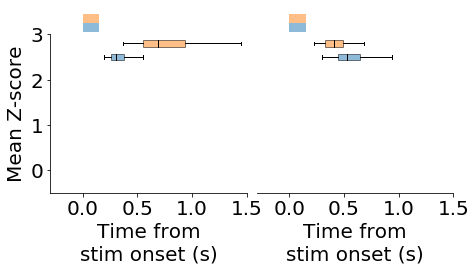

In [31]:
mpl.close('all')
fig2b_3 = mpl.figure(figsize = (8,4))

gs1 = gridspec.GridSpec(1,2)
gs2 = gridspec.GridSpec(1,2)

gs1.update(bottom=0.25, top=0.8, left = 0.15, right = 0.85, wspace=0.05)
gs2.update(bottom = 0.81, top=0.87, left = 0.15, right = 0.85, wspace=0.05)

colors = ['C0', 'C1',]

ax1 = mpl.subplot(gs1[0, 0])
ax2 = mpl.subplot(gs1[0, 1],sharey=ax1, sharex = ax1)

axs = [ax1,ax2]
xvals = np.arange(-1,3,bin_size)


for i, col in enumerate(list(data.keys())):
    trial_types = data[col]
    ax = mpl.subplot(gs2[0, i],sharex=axs[i])
    ax.add_patch(patches.Rectangle((0,0), 0.15, 1, facecolor = 'C0', alpha = 0.5))
    ax.add_patch(patches.Rectangle((0,1), 0.15, 2, facecolor = 'C1', alpha = 0.5))
    ax.set_ylim(0,2)

    ax.axis('off')

    for tt in trial_types:
        z_map = tt
        m_psth = z_map.mean(axis = 0)
        sem_psth = scipy.stats.sem(z_map, axis = 0, nan_policy = 'omit')
        axs[i].plot(xvals[:-1],m_psth)
        axs[i].fill_between(xvals[0:-1], m_psth-sem_psth, m_psth+sem_psth,alpha=0.5,)
        axs[i].set_xticks(np.arange(-1,1.6,0.5))
        axs[i].set_xlim(-0.3,1)
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['top'].set_visible(False)
        axs[i].set_xlabel('Time from\nstim onset (s)')
        if i>0:
            axs[i].axes.get_yaxis().set_visible(False)
            axs[i].spines['left'].set_visible(False)
            
ylim = ax1.get_ylim()

bplot1 = ax1.boxplot([reaction_times['RT_med_TLR_fterc'],reaction_times['RT_med_VLL_tterc']], 
                     vert = False, positions = [2.5,2.8], showfliers = False,patch_artist = True)
bplot2 = ax2.boxplot([reaction_times['RT_med_TLR_tterc'],reaction_times['RT_med_VLL_fterc']],
                     vert = False, positions = [2.5,2.8], showfliers = False,patch_artist = True)
ax1.set_ylim(-0.5, 3)
ax1.set_ylim(-0.5, 3)
ax1.set_xlim(-0.3, 1.5)

ax1.set_yticks([0,1,2,3])
ax1.set_yticklabels([0,1,2, 3])

axs[0].set_ylabel('Mean Z-score')
# axs[-1].text(.45, .16, "Touch block" , transform=axs[i].transAxes, color = colors[0])
# axs[-1].text(.45, .05, "Visual block" , transform=axs[i].transAxes, color = colors[1])
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
            mpl.setp(bplot[element], color='k')
        patch.set_facecolor(color)
        patch.set_alpha(0.5)

ylim_hit_psth = axs[0].get_ylim()

# fig2b_3

In [33]:
# fig2b_3.savefig('fig3_suppB.tiff',format='tiff', dpi = 900)

In [34]:
data = {}

columns = [['t_stim_no_lick(z_score)', 't_stim_lick_first_terc(z_score)', 't_stim_lick_second_terc(z_score)',
           't_stim_lick_third_terc(z_score)'],['v_stim_no_lick(z_score)', 'v_stim_lick_first_terc(z_score)',
           'v_stim_lick_second_terc(z_score)', 'v_stim_lick_third_terc(z_score)']]

for i,col in enumerate(columns):
    data[i] = [pd.DataFrame(np.stack(sub_map[z_map].as_matrix())) for z_map in col]


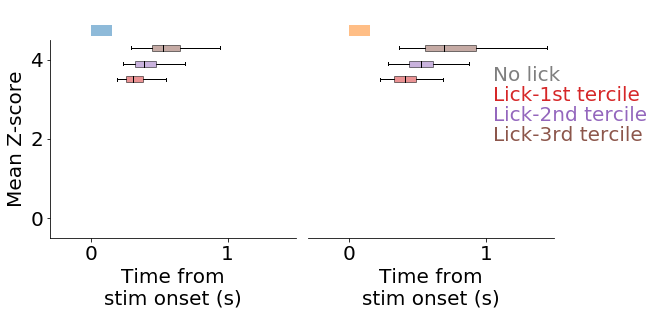

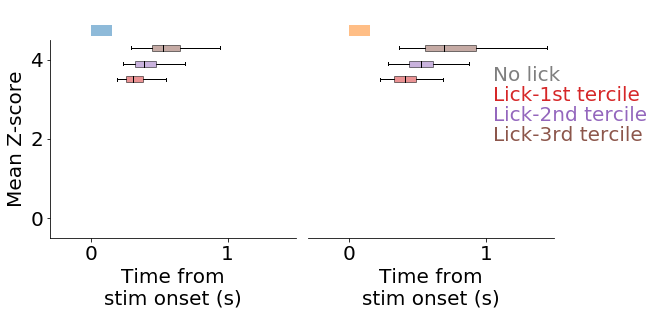

In [35]:
mpl.close('all')
fig2b_3 = mpl.figure(figsize = (10,5))

gs1 = gridspec.GridSpec(1,2)
gs2 = gridspec.GridSpec(1,2)

gs1.update(bottom=0.25, top=0.8, left = 0.15, right = 0.85, wspace=0.05)
gs2.update(bottom = 0.81, top=0.87, left = 0.15, right = 0.85, wspace=0.05)


colors = ['C0', 'C1',]

ax1 = mpl.subplot(gs1[0, 0])
ax2 = mpl.subplot(gs1[0, 1],sharey=ax1, sharex = ax1)
ax3 = mpl.subplot(gs2[0, 0], sharex=ax1)
ax4 = mpl.subplot(gs2[0, 1], sharex=ax2)
ax3.add_patch(patches.Rectangle((0,0), 0.15, 1, facecolor = 'C0', alpha = 0.5))
ax4.add_patch(patches.Rectangle((0,0), 0.15, 1, facecolor = 'C1', alpha = 0.5))

for ax in [ax3,ax4]:
    ax.set_ylim(0,2)
    ax.axis('off')

axs = [ax1,ax2]
xvals = np.arange(-1,3,bin_size)
for i, col in enumerate(list(data.keys())):
    trial_types = data[col]

    colors = ['C7', 'C3', 'C4', 'C5']
    for j,tt in enumerate(trial_types):
        z_map = tt
        m_psth = z_map.mean(axis = 0)
        sem_psth = scipy.stats.sem(z_map, axis = 0, nan_policy = 'omit')
        axs[i].plot(xvals[:-1],m_psth, color = colors[j])
        axs[i].fill_between(xvals[0:-1], m_psth-sem_psth, m_psth+sem_psth,alpha=0.5, color = colors[j])
        axs[i].set_xticks(np.arange(-1,3,1))
        axs[i].set_xlim(-0.3,1)
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['top'].set_visible(False)
        axs[i].set_xlabel('Time from\nstim onset (s)')
        if i>0:
            axs[i].axes.get_yaxis().set_visible(False)
            axs[i].spines['left'].set_visible(False)
        
axs[0].set_ylabel('Mean Z-score')
axs[-1].text(.75, .79, "No lick" , transform=axs[i].transAxes, color = 'C7')
axs[-1].text(.75, .69, "Lick-1st tercile" , transform=axs[i].transAxes, color = 'C3')
axs[-1].text(.75, .59, "Lick-2nd tercile" , transform=axs[i].transAxes, color = 'C4')
axs[-1].text(.75, .49, "Lick-3rd tercile" , transform=axs[i].transAxes, color = 'C5')

bplot1 = ax1.boxplot([reaction_times['RT_med_TLR_fterc'],reaction_times['RT_med_TLR_sterc'], 
                      reaction_times['RT_med_TLR_tterc']], vert = False, positions = [3.5,3.9,4.3], 
                     showfliers = False, patch_artist = True)
bplot2 = ax2.boxplot([reaction_times['RT_med_VLL_fterc'],reaction_times['RT_med_VLL_sterc'], 
                      reaction_times['RT_med_VLL_tterc']], vert = False, positions = [3.5,3.9,4.3], 
                     showfliers = False , patch_artist = True)
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors[1:]):
        for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
            mpl.setp(bplot[element], color='k')
        patch.set_facecolor(color)
        patch.set_alpha(0.5)


ax1.set_ylim(-0.5,4.5)
ax1.set_xlim(-0.3,1.5)
ax1.set_yticks([0,2,4])
ax1.set_yticklabels([0,2,4])

ylim_hit_psth = axs[0].get_ylim()

fig2b_3

In [36]:
# fig2b_3.savefig('fig3_suppB.tiff',format='tiff', dpi = 900)

In [ ]:
z_scored_df = pd.read_hdf('z_scored_df.h5', 'table')


In [ ]:
sub_map = z_scored_df.merge(bimodal_lick_units, on = id_cols, how = 'inner')

In [ ]:
data[z_map] = pd.DataFrame(np.stack(sub_map[z_map].as_matrix()))